In [ ]:
import yfinance as yf
from pathlib import Path
from datetime import date, timedelta, datetime, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import rsi
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pd.options.mode.copy_on_write = True


def fetch_ticker(ticker="^GSPC", start="1990-01-01", interval="15m"):
    end = date.today()
    if interval == "1h":
        start = end - timedelta(days=720)
    p = Path(f"data/cache/{interval}/{ticker}.csv")
    p.parent.mkdir(parents=True, exist_ok=True)
    if not p.is_file() or date.fromtimestamp(p.stat().st_mtime) < date.today():
        data = yf.download(
            ticker, start=start, end=end, interval=interval, prepost=True
        )
        data.columns = data.columns.droplevel(-1)
        data.to_csv(p)
    else:
        data = pd.read_csv(p, index_col=0, parse_dates=[0])
    return data


vix_data = fetch_ticker("^VIX", interval="1d", start="1985-01-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
def calculate_moving_avg_std(
    data: pd.DataFrame, column: str, window: int = 30
):
    data[f"{window}_MA"] = (
        data[column].rolling(window=window, min_periods=1).mean()
    )
    data[f"{window}_STD"] = (
        data[column].rolling(window=window, min_periods=1).std()
    )
    window = 200
    data[f"{window}_MA"] = (
        data[column].rolling(window=window, min_periods=1).mean()
    )
    window = 50
    data[f"{window}_MA"] = (
        data[column].rolling(window=window, min_periods=1).mean()
    )
    return data


def calculate_volume_indicators(data: pd.DataFrame, window: int = 30):
    data[f"vol_{window}_MA"] = (
        data["Volume"].rolling(window=window, min_periods=1).mean()
    )
    data["Volume_Deviation"] = (
        (data["Volume"] - data[f"vol_{window}_MA"]) / data[f"vol_{window}_MA"]
    ) * 100

    return data

In [ ]:
from ta.trend import MACD
from scipy.signal import find_peaks


def prepare_dataset(df: pd.DataFrame, timeframe: int):
    df["MA50"] = df["Close"].rolling(window=50).mean()
    df["MA200"] = df["Close"].rolling(window=200).mean()
    df[f"{timeframe}MA"] = df["Close"].rolling(window=timeframe).mean()
    df[f"{timeframe}STD"] = df["Close"].rolling(window=timeframe).std()
    df["Upper_BB"] = df[f"{timeframe}_MA"] + 2 * df[f"{timeframe}_STD"]
    df["Lower_BB"] = df[f"{timeframe}_MA"] - 2 * df[f"{timeframe}_STD"]
    df["Center_BB"] = df["Upper_BB"] - (df["Upper_BB"] - df["Lower_BB"]) / 2
    df["Center_BB_Div"] = (
        (df["Close"] - df["Center_BB"])
        / (df["Upper_BB"] - df["Lower_BB"])
        * 100
    )
    df["RSI"] = rsi(df["Close"], window=14)
    macd = MACD(df["Close"], window_fast=12, window_slow=26, window_sign=9)
    df["MACD"] = macd.macd()
    df["MACD_signal"] = macd.macd_signal()
    df["MACD_hist"] = macd.macd_diff()
    df["Slope"] = df["Close"].diff()
    df["Turning_Points"] = (
        (df["Slope"].shift(1) > 0) & (df["Slope"] < 0)
    ).astype(int)
    df["Acceleration"] = df["Slope"].diff()
    df["Momentum"] = df["Close"] - df["Close"].shift(5)
    df["DayOfWeek"] = df.index.day_of_week
    df["Change"] = df["Close"].pct_change()
    df["UpperBreak"] = (df["Upper_BB"] < df["Close"]).astype(int)
    df["LowerBreak"] = (df["Lower_BB"] > df["Close"]).astype(int)
    df["MA50_rel"] = df["Close"] - df["MA50"]
    df["MA200_rel"] = df["Close"] - df["MA200"]
    df["DayOfWeek_sin"] = np.sin(2 * np.pi * df["DayOfWeek"] / 7)
    df["DayOfWeek_cos"] = np.cos(2 * np.pi * df["DayOfWeek"] / 7)
    df.drop(columns=["DayOfWeek"], inplace=True)

    # Find peaks (local maxima)
    peaks, _ = find_peaks(
        df["Close"], distance=4
    )  # Distance=10 ensures minimum separation
    troughs, _ = find_peaks(
        -df["Close"], distance=4
    )  # Invert to find local minima

    peak_indices = df.index[peaks]  # Convert position to index
    trough_indices = df.index[troughs]
    df["Target"] = 0  # Default: No peak or trough
    df.loc[peak_indices, "Target"] = 1  # Mark peaks
    df.loc[trough_indices, "Target"] = -1  # Mark troughs

    # df.loc[X.index, "Predicted"] = model.predict(X)
    return df

In [25]:
def plot_entry_and_exit_points(stock_data: pd.DataFrame, ma: int = 325):
    # Create a subplot with 2 rows: the upper row for price data, lower row for volume
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.7, 0.3],
    )  # Adjust row heights as needed

    # --- Price Plot (Row 1) ---
    # Add closing price line
    fig.add_trace(
        go.Scatter(
            x=stock_data.index,
            y=stock_data["Close"],
            mode="lines",
            name="Closing Price",
            line=dict(color="blue"),
        ),
        row=1,
        col=1,
    )

    # Add moving average line
    fig.add_trace(
        go.Scatter(
            x=stock_data.index,
            y=stock_data[f"{ma}_MA"],
            mode="lines",
            name="Moving Average",
            line=dict(color="yellow"),
        ),
        row=1,
        col=1,
    )

    # Add long entry and exit markers
    long_entry_indices = stock_data.index[stock_data["Long_Entry"]]
    long_entry_prices = stock_data["Close"][stock_data["Long_Entry"]]
    long_exit_indices = stock_data.index[stock_data["Long_Exit"]]
    long_exit_prices = stock_data["Close"][stock_data["Long_Exit"]]

    fig.add_trace(
        go.Scatter(
            x=long_entry_indices,
            y=long_entry_prices,
            mode="markers",
            name="Long Entry Signal",
            marker=dict(color="green", size=10, symbol="circle"),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=long_exit_indices,
            y=long_exit_prices,
            mode="markers",
            name="Long Exit Signal",
            marker=dict(color="red", size=10, symbol="circle"),
        ),
        row=1,
        col=1,
    )

    # Plot holding period segments separately to avoid unwanted connections
    segments = []
    current_segment = []
    for i in range(len(stock_data)):
        if stock_data["Position"].iloc[i] == 1:
            current_segment.append(
                (stock_data.index[i], stock_data["Close"].iloc[i])
            )
        else:
            if current_segment:
                segments.append(current_segment)
                current_segment = []
    if current_segment:
        segments.append(current_segment)

    for segment in segments:
        x_vals, y_vals = zip(*segment)
        fig.add_trace(
            go.Scatter(
                x=x_vals,
                y=y_vals,
                mode="lines",
                name="Holding Period",
                line=dict(color="purple", width=3),
                opacity=0.8,
            ),
            row=1,
            col=1,
        )

    # --- Volume Plot (Row 2) ---
    fig.add_trace(
        go.Bar(
            x=stock_data.index,
            y=stock_data["Volume"],
            name="Volume",
            marker=dict(color="green"),
        ),
        row=2,
        col=1,
    )

    if f"vol_{ma}_MA" in stock_data.columns:
        # Overlay vol_ma_MA as a line
        fig.add_trace(
            go.Scatter(
                x=stock_data.index,
                y=stock_data[f"vol_{ma}_MA"],
                mode="lines",
                name=f"vol_{ma}_MA",
                line=dict(color="orange"),
            ),
            row=2,
            col=1,
        )

    # Update layout for better viewing
    fig.update_layout(
        title="Stock Closing Price with Long Entry Signals and Volume",
        xaxis_title="Date",
        yaxis_title="Price",
        template="plotly_dark",
        hovermode="x unified",
        height=700,
    )
    # Set y-axis title for the volume subplot
    fig.update_yaxes(title_text="Volume", row=2, col=1)

    fig.show()

In [26]:
def over_lower_bb(stock_data: pd.DataFrame):
    return stock_data["Close"] >= stock_data["Lower_BB"]


def under_lower_bb(stock_data: pd.DataFrame):
    return stock_data["Close"] < stock_data["Lower_BB"]


def rsi_trending_up(stock_data: pd.DataFrame):
    average = stock_data["rsi"].rolling(window=30).mean()
    return (stock_data["rsi"] >= 30) & (stock_data["rsi"] > average)


def crossing_50_through_200(stock_data: pd.DataFrame):
    # bearish signal
    return (stock_data["50_MA"].shift() > stock_data["200_MA"].shift()) & (
        stock_data["50_MA"] <= stock_data["200_MA"]
    )


def crossing_200_through_50(stock_data: pd.DataFrame):
    # bullish signal
    return (stock_data["50_MA"].shift() >= stock_data["200_MA"].shift()) & (
        stock_data["50_MA"] <= stock_data["200_MA"]
    )


def overbought_rsi_bb(stock_data: pd.DataFrame):
    return (stock_data["Close"] > stock_data["Upper_BB"]) & (
        stock_data["rsi"] > 70
    )


def oversold_rsi_bb(stock_data: pd.DataFrame):
    return (stock_data["Center_BB_Div"] <= -50) & (stock_data["rsi"] < 35)


def new_month_high(stock_data: pd.DataFrame, window: int = 30):
    # new maximum, but following value is lower
    rolling_max = stock_data["Close"].rolling(window=window).max()
    return (stock_data["Close"].shift() > rolling_max.shift(2)) & (
        stock_data["Close"] < stock_data["Close"].shift()
    )


def over_window_ma(stock_data: pd.DataFrame, window):
    return stock_data["Close"] > stock_data[f"{window}_MA"]


def bb_reversal(stock_data: pd.DataFrame):
    return (
        (stock_data["Open"].shift() < stock_data["Lower_BB"].shift())
        | (stock_data["Close"].shift() < stock_data["Lower_BB"].shift())
    ) & (stock_data["Close"] > stock_data["Lower_BB"])


def new_month_low(stock_data: pd.DataFrame, window: int = 30):
    # new minimum, but following value is higher
    rolling_min = stock_data["Close"].rolling(window=window).min()
    return (stock_data["Close"].shift() < rolling_min.shift(2)) & (
        stock_data["Close"] > stock_data["Close"].shift()
    )


def low_vix_and_falling(stock_data: pd.DataFrame, vix_data: pd.DataFrame):
    stock_avg = stock_data["Close"].rolling(window=14).mean()
    return (stock_data["Close"] < stock_avg) & (vix_data["Close"] < 17)


def close_roughly_equal_low(stock_data: pd.DataFrame, vix_data: pd.DataFrame):
    candle_breadth = stock_data["High"] - stock_data["Low"]
    lower_stick = stock_data["Close"] - stock_data["Low"]
    return (
        (lower_stick.shift() < 1)
        | (lower_stick.shift() / candle_breadth.shift() < 0.1)
    ) & (vix_data["Close"].shift() < vix_data["Close"])


def crossing_200ma_down(stock_data: pd.DataFrame):
    volume_avg = (
        stock_data["Volume"].rolling(window=30).mean()
    )  # 30-day moving average
    return (
        (stock_data["Close"].shift() > stock_data["200_MA"].shift())
        & (stock_data["Close"] < stock_data["200_MA"])
        & (stock_data["Volume"] > volume_avg)
    )


def volume_above_avg(stock_data: pd.DataFrame):
    volume_avg = stock_data["Volume"].rolling(window=30).mean()
    return stock_data["Volume"] > volume_avg


def above_200ma(stock_data: pd.DataFrame):
    return (stock_data["Close"] > stock_data["200_MA"]) & volume_above_avg(
        stock_data
    )


def above_n_ma(stock_data: pd.DataFrame, n: int):
    return stock_data["Close"] > stock_data[f"{n}_MA"]


def below_n_ma(stock_data: pd.DataFrame, n: int):
    return stock_data["Close"] < stock_data[f"{n}_MA"]


def stop_loss_triggerd(stock_data: pd.DataFrame, percent: int):
    stock_data["Change"] < -percent / 100


def reached_target_profit(stock_data: pd.DataFrame, percent: int):
    stock_data["Change"] > percent


def below_200ma(stock_data: pd.DataFrame):
    return (stock_data["Close"] < stock_data["200_MA"]) & volume_above_avg(
        stock_data
    )

In [27]:
def calculate_max_drawdown(returns: pd.Series) -> float:
    # Compute cumulative returns assuming reinvestment
    cumulative_returns = (1 + returns).cumprod()
    # Determine the running maximum of the cumulative returns
    running_max = cumulative_returns.cummax()
    # Calculate drawdown as the relative drop from the running max
    drawdown = (cumulative_returns - running_max) / running_max
    # Maximum drawdown is the minimum value of drawdown (most negative)
    return drawdown.min()

In [73]:
# Backtesting Ivan Scherman's strategy with leverage and risk management
def backtest_strategy(
    raw_data: pd.DataFrame,
    raw_vix_data: pd.DataFrame,
    leverage: int = 3,
    print_graphs: bool = True,
    moving_avg: int = 325,
    long_entry: pd.Series = None,
    long_exit: pd.Series = None,
):
    # Ensure data is aligned
    stock_data = raw_data.copy()
    vix_data = raw_vix_data.copy()
    stock_data, vix_data = stock_data.align(vix_data, join="inner", axis=0)
    # Calculate moving average and standard deviation for S&P 500
    stock_data = calculate_moving_avg_std(
        stock_data, "Close", window=moving_avg
    )
    stock_data = calculate_volume_indicators(stock_data, window=moving_avg)

    # Identify divergences
    stock_data = prepare_dataset(stock_data, moving_avg)
    stock_data.to_csv("gspc_daily_with_indicators.csv")
    # define all indicators above this line
    # ------------------------------------------------------------------------------------------

    # Define entry and exit signals
    if long_entry is None:
        long_entry = stock_data["Close"].shift(1) > stock_data[
            f"{moving_avg}_MA"
        ].shift(1)
    if long_exit is None:
        exit_condition = stock_data["Close"].shift(1) <= stock_data[
            f"{moving_avg}_MA"
        ].shift(1)
        n = 1
        long_exit = (exit_condition.rolling(window=n).sum() == n) & (
            stock_data["Volume_Deviation"].shift(1) > 0
        )
    stock_data["Long_Entry"] = long_entry
    stock_data["Long_Exit"] = long_exit
    # stock_data["Long_Exit"] = over_window_ma(stock_data, moving_avg) | under_lower_bb(stock_data)

    # Simulate trades
    stock_data["Position"] = 0
    print(stock_data)
    stock_data = execute_savings_plan(stock_data, leverage=1)
    stock_data = execute_savings_plan(stock_data, leverage=leverage)
    print(stock_data)
    # portfolio_return = (1 + stock_data["Portfolio_Return"]).cumprod()
    cumulative_market_return = (
        stock_data["Portfolio_lev1_hold"].pct_change().cumprod()
    )
    cumulative_market_return_lev = (
        stock_data[f"Portfolio_lev{leverage}_hold"].pct_change().cumprod()
    )
    # cumulative_strategy_return_lev = (
    #     1 + stock_data["Strategy_Return_Lev"]
    # ).cumprod()
    # cumulative_market_return = (1 + stock_data["Daily_Return"]).cumprod()
    if print_graphs:
        plot_entry_and_exit_points(stock_data, moving_avg)
        # Plot results
        plt.figure(figsize=(18, 6))
        # plt.plot(
        #     cumulative_strategy_return,
        #     label="Strategy Return",
        # )
        # plt.plot(
        #     cumulative_strategy_return_lev,
        #     label="Strategy Return with Leverage",
        # )
        plt.plot(
            cumulative_market_return,
            label="Market Return",
            markevery=stock_data["Long_Entry"],
        )
        plt.plot(cumulative_market_return_lev, label="Market Return leveraged")
        plt.title(
            "Ivan Scherman's Strategy Backtest with Leverage and no Risk Management"
        )
        plt.legend()
        plt.show()

    # Print performance metrics
    total_market_return = cumulative_market_return.iloc[-1] - 1
    total_market_return_lev = cumulative_market_return_lev.iloc[-1] - 1
    # total_strategy_return = cumulative_strategy_return.iloc[-1] - 1
    # total_strategy_return_lev = cumulative_strategy_return_lev.iloc[-1] - 1
    sharpe_ratio = (
        stock_data["Strategy_Return_Lev"].mean()
        / stock_data["Strategy_Return_Lev"].std()
        * np.sqrt(252)
    )
    if print_graphs:
        return_columns = [
            "Daily_Return",
            "Daily_Return_lev",
            "Strategy_Return",
            "Strategy_Return_Lev",
        ]
        max_drawdowns = {}

        for col in return_columns:
            max_drawdowns[col] = calculate_max_drawdown(stock_data[col])
            print(f"Maximum Drawdown for {col}: {max_drawdowns[col]}")
        # print(f"Total Strategy Return: {total_strategy_return:.2%}")
        # print(f"Total Strategy Return Lev: {total_strategy_return_lev:.2%}")
        print(f"Total Market Return: {total_market_return:.2%}")
        print(f"Total Market Return Leveraged: {total_market_return_lev:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    # plot_actual_value(stock_data)
    return (
        total_market_return,
        total_market_return_lev,
        # total_strategy_return,
        # total_strategy_return_lev,
        stock_data,
    )


def calculate_with_factor_cert(stock_data, leverage):
    pos_idx = stock_data.columns.get_loc("Position")
    for i in range(1, len(stock_data)):
        if (
            stock_data["Long_Entry"].iloc[i]
            and not stock_data["Long_Exit"].iloc[i]
        ):
            stock_data.iat[i, pos_idx] = 1
        elif (
            stock_data["Long_Exit"].iloc[i]
            and stock_data["Position"].iloc[i - 1] == 1
        ):
            stock_data.iat[i, pos_idx] = 0
        else:
            stock_data.iat[i, pos_idx] = stock_data["Position"].iloc[i - 1]
    stock_data["Daily_Return"] = stock_data["Close"].pct_change()
    stock_data["Daily_Return_lev"] = (
        stock_data["Close"].pct_change() * leverage
    )
    stock_data["Strategy_Return"] = (
        stock_data["Position"].shift() * stock_data["Daily_Return"]
    )
    stock_data["Strategy_Return_Lev"] = (
        stock_data["Position"].shift() * stock_data["Daily_Return"] * leverage
    )
    return stock_data


def execute_savings_plan(
    stock_data: pd.DataFrame,
    monthly_investment: int = 1000,
    leverage: int = 1,
    start_cash: int = 10000,
    strategy: bool = False,
):
    ptf_key = "hold"
    if strategy:
        ptf_key = "strategy"

    data = stock_data.copy()
    data.index = pd.to_datetime(data.index)

    date = data.index[0]
    close_price = data["Close"].iloc[0]

    data[f"cash_{ptf_key}"] = 0.0

    # Setup shares & portfolio
    data[f"shares_lev{leverage}_{ptf_key}"] = start_cash/close_price
    data[f"portfolio_lev{leverage}_{ptf_key}"] = (
        data.at[date, f"shares_lev{leverage}_{ptf_key}"] * close_price
    )
    changes = data["Close"].pct_change()
    for i in range(len(data)):
        date = data.index[i]
        change = changes.iloc[i]

        # set current shares to match previous day
        previous_shares = data[f"shares_lev{leverage}_{ptf_key}"].iloc[i-1]
        data.at[date, f"shares_lev{leverage}_{ptf_key}"] = previous_shares

        # if first of month invest again
        if date.day == 1:
            close_price = data["Close"].iloc[i]
            new_shares = monthly_investment / close_price
            shares_status = previous_shares + new_shares
            print(f"Bought {new_shares} shares.")
            print(f"Previous shares: {previous_shares}")
            data.at[date, f"shares_lev{leverage}_{ptf_key}"] = shares_status
        if i > 0:
            previous_value = data[f"portfolio_lev{leverage}_{ptf_key}"].iloc[i - 1]
            data.at[date, f"portfolio_lev{leverage}_{ptf_key}"] = (
                previous_value + previous_value * (change * leverage)
            )
    return data


def add_strategy_savings_plan(
    stock_data: pd.DataFrame,
    monthly_investment: int = 1000,
    leverage: int = 2,
    start_cash: int = 10000,
):
    """
    Simulate a savings plan with monthly contributions and full liquidation on exit signals.

    When a long entry signal is active on the first day of the month, a fixed amount (monthly_investment)
    is added to cash and if not already invested, the entire cash is used to buy shares. If already invested,
    the monthly contribution is used to buy additional shares.

    On any day a long exit signal occurs, the entire position is sold.

    This function also calculates:
      - Daily_Return: the pct change of the underlying 'Close' price.
      - Daily_Return_lev: the leveraged daily return.
      - Strategy_Return: the return when invested (Position shifted by one day * Daily_Return).
      - Strategy_Return_Lev: leveraged version of the strategy return.
      - Portfolio_Return: the pct change in overall portfolio value.

    Assumptions:
      - stock_data has a DateTimeIndex.
      - It contains 'Close', 'Long_Entry', and 'Long_Exit' columns.
    """
    # Work on a copy to preserve original data
    data = stock_data.copy()
    data.index = pd.to_datetime(data.index)

    # Initialize tracking columns

    data["Portfolio_Strategy"] = 10000.0
    data["Position"] = 0  # 1 when invested, 0 when not

    cash = 10000.0
    shares = 0.0

    # Loop over each day in the dataset
    for i in range(len(data)):
        date = data.index[i]
        close_price = data["Close"].iloc[i]
        entry_signal = data["Long_Entry"].iloc[i]
        exit_signal = data["Long_Exit"].iloc[i]

        # On an exit signal, if currently invested, sell all shares
        if exit_signal and shares > 0:
            cash = shares * close_price
            shares = 0.0

        # On an entry signal:
        if entry_signal:
            # On the first day of the month, add the monthly contribution
            if date.day == 1:
                cash += monthly_investment

            # If not invested, invest all available cash
            if shares == 0 and cash > 0:
                shares = cash / close_price
                cash = 0.0
            # If already invested and it's the first day, add monthly contribution and buy additional shares
            elif shares > 0 and date.day == 1:
                # cash already updated above with monthly_investment
                additional_shares = cash / close_price
                shares += additional_shares
                cash = 0.0

        # Set Position: 1 if holding shares, 0 otherwise
        position = 1 if shares > 0 else 0
        data.at[date, "Position"] = position

        # Update the portfolio value (cash + value of shares)
        portfolio_value = cash + shares * close_price
        data.at[date, "Cash"] = cash
        data.at[date, "Shares"] = shares
        data.at[date, "Portfolio_Strategy"] = portfolio_value

    return data

In [74]:
def test_ticker_through_timeframes(
    stock_data: pd.DataFrame,
    vix_data: pd.DataFrame,
    year_length: int = 2,
    leverage: int = 3,
    moving_avg: int = 30,
):
    edit_data_vix = vix_data.copy()
    edit_data = stock_data.copy()
    edit_data.index = pd.to_datetime(edit_data.index)
    edit_data_vix.index = pd.to_datetime(edit_data_vix.index)
    start_year = edit_data.index[0].year
    results = []
    results_lev = []
    market_results = []
    market_results_lev = []
    while start_year != date.today().year - year_length:
        target_year = start_year + year_length
        market, market_lev, strategy, strategy_lev, _ = backtest_strategy(
            edit_data[
                (edit_data.index.year >= start_year)
                & (edit_data.index.year <= target_year)
            ],
            edit_data_vix[
                (edit_data_vix.index.year >= start_year)
                & (edit_data_vix.index.year <= target_year)
            ],
            leverage=leverage,
            print_graphs=False,
            moving_avg=moving_avg,
        )
        results.append(strategy)
        results_lev.append(strategy_lev)
        market_results.append(market)
        market_results_lev.append(market_lev)
        start_year += 1
        # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(
        results,
        label="Strategy Return",
    )
    plt.plot(
        results_lev,
        label="Strategy Return with Leverage",
    )
    plt.plot(market_results, label="Market Return")
    plt.plot(market_results_lev, label="Market Return Leveraged")
    plt.title(
        "Ivan Scherman's Strategy Backtest in 2 year blocks from 1990-2025"
    )
    plt.legend()
    plt.show()
    print(
        f"{sum(1 if results[i]>market_results[i] else 0 for i, _ in enumerate(results))/len(results)*100}% of year ranges outperform the market"
    )
    print(
        f"{sum(1 if results_lev[i]>market_results_lev[i] else 0 for i, _ in enumerate(results_lev))/len(results_lev)*100}% of *leveraged* year ranges outperform the market"
    )
    print(results)
    print(market_results)
    _, _, _, _, data = backtest_strategy(
        edit_data, edit_data_vix, leverage=leverage
    )
    return data

In [75]:
data = fetch_ticker("^GSPC", interval="1d")
# data = data[data.index > '2018-11-07']
(
    total_market_return,
    total_market_return_lev,
    total_strategy_return,
    total_strategy_return_lev,
    stock_data,
) = backtest_strategy(data, vix_data, leverage=3, moving_avg=325)
# analysed_data = test_ticker_through_timeframes(data, vix_data,year_length=2,leverage=2,moving_avg=325)
# stock_data.describe()

                  Close         High          Low         Open      Volume  \
Date                                                                         
1990-01-02   359.690002   359.690002   351.980011   353.399994   162070000   
1990-01-03   358.760010   360.589996   357.890015   359.690002   192330000   
1990-01-04   355.670013   358.760010   352.890015   358.760010   177000000   
1990-01-05   352.200012   355.670013   351.350006   355.670013   158530000   
1990-01-08   353.790009   354.239990   350.540009   352.200012   140110000   
...                 ...          ...          ...          ...         ...   
2025-03-18  5614.660156  5654.529785  5597.759766  5654.529785  4666270000   
2025-03-19  5675.290039  5715.330078  5622.200195  5632.370117  4660090000   
2025-03-20  5662.890137  5711.149902  5632.330078  5646.919922  4678420000   
2025-03-21  5667.560059  5670.839844  5603.100098  5630.729980  9367460000   
2025-03-24  5767.569824  5775.140137  5718.080078  5718.080078  

KeyError: 'Portfolio_lev1_hold'

In [23]:
stock_data["Close"].pct_change(), stock_data["Close"]

(Date
 1990-01-02         NaN
 1990-01-03   -0.002586
 1990-01-04   -0.008613
 1990-01-05   -0.009756
 1990-01-08    0.004514
                 ...   
 2025-03-18   -0.010654
 2025-03-19    0.010798
 2025-03-20   -0.002185
 2025-03-21    0.000825
 2025-03-24    0.017646
 Name: Close, Length: 8872, dtype: float64,
 Date
 1990-01-02     359.690002
 1990-01-03     358.760010
 1990-01-04     355.670013
 1990-01-05     352.200012
 1990-01-08     353.790009
                  ...     
 2025-03-18    5614.660156
 2025-03-19    5675.290039
 2025-03-20    5662.890137
 2025-03-21    5667.560059
 2025-03-24    5767.569824
 Name: Close, Length: 8872, dtype: float64)

In [ ]:
from tqdm.notebook import tqdm

x = fetch_ticker()
x = prepare_dataset(x)
x["Predicted_Close"] = 0
x["Predicted_Target"] = 0
x = x[x.index > "2024-01-01"]
forecast_horizon = 5
lookback = 30
for i in tqdm(range(lookback, len(x) - forecast_horizon)):
    past_data = x.iloc[:i]  # Get data up to the current index
    predicted_changes, predicted_targets = predict(past_data)
    # Store only the first predicted value (1 step ahead)
    # print(predicted_changes)
    # print(predicted_targets)
    # print(i)
    x.loc[x.index[i + 1], "Predicted_Change"] = predicted_changes[0]
    x.loc[x.index[i + 1], "Predicted_Close"] = x.iloc[i]["Close"] * (
        predicted_changes[0] + 1
    )
    x.loc[x.index[i + 1], "Predicted_Target"] = predicted_targets[0]
    # print(x.iloc[i+1])
    # break

x["Predicted_Target"] = x["Predicted_Target"].astype("Int64")

  0%|          | 0/241 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


/tmp/ipykernel_219726/3647940626.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4999.542120154059' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  x.loc[x.index[i+1], "Predicted_Close"] = x.iloc[i]["Close"]*(predicted_changes[0]+1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from copy import deepcopy

edit_data = deepcopy(data)
edit_data.columns = edit_data.columns.droplevel(-1)
edit_data_vix = deepcopy(data_vix)
edit_data_vix.columns = edit_data_vix.columns.droplevel(-1)
tracked = backtest_strategy(edit_data, edit_data_vix, leverage=3)
# backtest_duennbier(edit_data, leverage=3)
max_yield = 0
rsi_in_best = -1
rsi_out_best = -1
for i in range(1, 60):
    for j in range(40, 100):
        rsi_in = i / 100
        rsi_out = j / 100
        strat_return = backtest_strategy(
            edit_data,
            edit_data_vix,
            leverage=3,
            rsi_in=rsi_in,
            rsi_out=rsi_out,
        )
        print(f"RSI_in: {rsi_in} RSI_out: {rsi_out} - Return: {strat_return}")
        if strat_return > max_yield:
            max_yield = strat_return
            rsi_in_best = rsi_in
            rsi_out_best = rsi_out
print(
    f"Best performance with: \nstoch_rsi_in: {rsi_in}\nstoch_rsi_out: {rsi_out}\nresult: {max_yield}"
)

ValueError: Cannot remove 1 levels from an index with 1 levels: at least one level must be left.

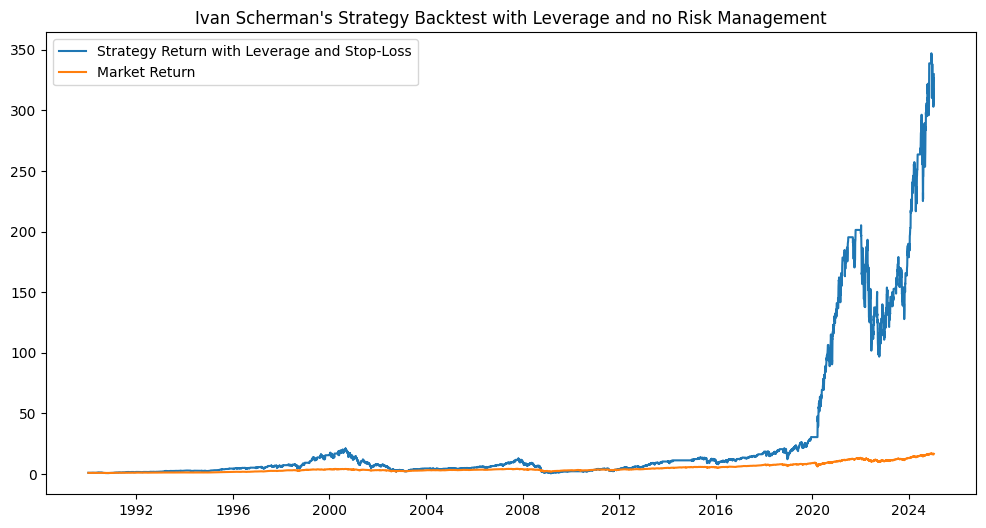

Total Strategy Return: 32884.62%
Total Market Return: 1567.17%
Sharpe Ratio: 0.58


In [ ]:
data = backtest_strategy(
    edit_data, edit_data_vix, leverage=3, rsi_in=0.59, rsi_out=0.99
)

In [ ]:
analysed_data.iloc[35:50]

,Close,High,Low,Open,Volume,30_MA,30_STD,Low_Low,Divergence,Upper_BB,Lower_BB,Long_Entry,Long_Exit,Position,Daily_Return,Daily_Return_lev,Strategy_Return,value_strategy,value_market
Date,,,,,,,,,,,,,,,,,,,
1990-02-21,327.670013,328.170013,324.470001,327.910004,159240000,332.919333,6.024857,True,False,344.969047,320.869618,False,False,0,-0.000976,-0.002927,-0.000000,1000.000000,910.978930
1990-02-22,325.700012,330.980011,325.700012,327.670013,184320000,332.199000,5.515274,True,True,343.229548,321.168452,True,False,1,-0.006012,-0.018036,-0.000000,1000.000000,905.501988
1990-02-23,324.149994,326.149994,322.100006,325.700012,148490000,331.386333,4.772050,True,True,340.930433,321.842233,True,False,2,-0.004759,-0.014277,-0.014277,985.722890,901.192671
1990-02-26,328.670013,328.670013,323.980011,324.160004,148900000,331.011001,4.512662,False,False,340.036324,321.985677,False,False,2,0.013944,0.041833,0.083665,1068.193724,913.759101
1990-02-27,330.260010,331.940002,328.470001,328.679993,152590000,330.786334,4.369727,False,False,339.525789,322.046879,False,False,2,0.004838,0.014513,0.029026,1099.199122,918.179564
1990-02-28,331.890015,333.480011,330.160004,330.260010,184400000,330.491001,3.952598,False,False,338.396197,322.585806,False,False,2,0.004936,0.014807,0.029613,1131.749837,922.711258
1990-03-01,332.739990,334.399994,331.079987,331.890015,157930000,330.335668,3.758520,False,False,337.852709,322.818627,False,False,2,0.002561,0.007683,0.015366,1149.140413,925.074336
1990-03-02,335.540009,335.540009,332.720001,332.739990,164330000,330.247335,3.595151,False,False,337.437638,323.057032,False,False,2,0.008415,0.025245,0.050490,1207.160747,932.858868
1990-03-05,333.739990,336.380005,333.489990,335.540009,140110000,330.067001,3.252553,False,False,336.572108,323.561895,False,False,2,-0.005365,-0.016094,-0.032187,1168.305563,927.854508


In [ ]:
from datetime import datetime, timedelta
import pytz

datetime.now(pytz.timezone("US/Eastern")).hour == 9
datetime.now(pytz.timezone("US/Eastern")).minute == 30  # closing 16

datetime.datetime(2025, 1, 25, 20, 20, 31, 254670, tzinfo=<DstTzInfo 'US/Eastern' EST-1 day, 19:00:00 STD>)